# Beijing Air Quality Forecasting Starter Notebook

## 1. Introduction into the Project

In this section, I provide an overview of the Beijing Air Quality Forecasting project, which is part of the **Machine Learning Techniques I** course. The goal of this project is to predict the PM2.5 concentrations in Beijing using historical air quality and weather data. These predictions can help mitigate the effects of air pollution on public health and urban planning.

To tackle this problem, we use Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models, which are well-suited for time-series forecasting tasks. The key objectives are:
- To preprocess the data and uncover temporal patterns.
- To design and train an RNN/LSTM model for accurate PM2.5 predictions.
- To fine-tune the model and run multiple experiments to optimize performance and aim for a top position on the Kaggle leaderboard.

The dataset provided contains historical air quality measurements and weather data. We will clean the data, preprocess it for sequential modeling, and then develop an RNN or LSTM model to make the predictions.

---

In [17]:
# libraries I used for the task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import optuna
from optuna.samplers import TPESampler
from google.colab import drive

In [18]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Loading the datasets
train = pd.read_csv('/content/drive/MyDrive/air_quality_forecasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/air_quality_forecasting/test.csv')


# Data Exploration

Before building the model, it’s essential to understand the dataset's structure and characteristics. In this section, we explore the dataset by:
- Checking the dataset’s general information, such as the number of samples, features, and data types.
- Investigating the distribution of the target variable (PM2.5) and the features (temperature, humidity, etc.).
- Plotting some visualizations to understand the trends and seasonal patterns in the data.

We also examine the correlations between various features, which could provide insights into how different variables influence PM2.5 concentrations.

In [20]:
# Display the first few rows of the training dataset
print("Training Data Overview:")
print(train.head())

# Display the first few rows of the test dataset
print("\nTest Data Overview:")
print(test.head())

# shape of the datasets
print("\nTraining Data Shape:", train.shape)
print("Test Data Shape:", test.shape)

# showing the column names and data types
print("\nTraining Data Columns and Data Types:")
print(train.info())

print("\nTest Data Columns and Data Types:")
print(test.info())

Training Data Overview:
   No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
2  2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
3  2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
4  2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    NaN  

Test Data Overview:
      No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0  30677  1.190496  0.701029 -2.186052 -0.003982 -0.069353 -0.137667   
1  30678  1.121211  0.61

In [21]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [22]:
# Convert 'datetime' column to datetime format and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

### **Missing Values Heatmap**
This heatmap visualizes missing values in the dataset.  
- Helps identify features with missing data.  
- Guides decisions on imputation (e.g., forward/backward fill).  
- Ensures no bias or information leakage in preprocessing.  

Missing data can distort patterns, making imputation crucial for reliable forecasting.  


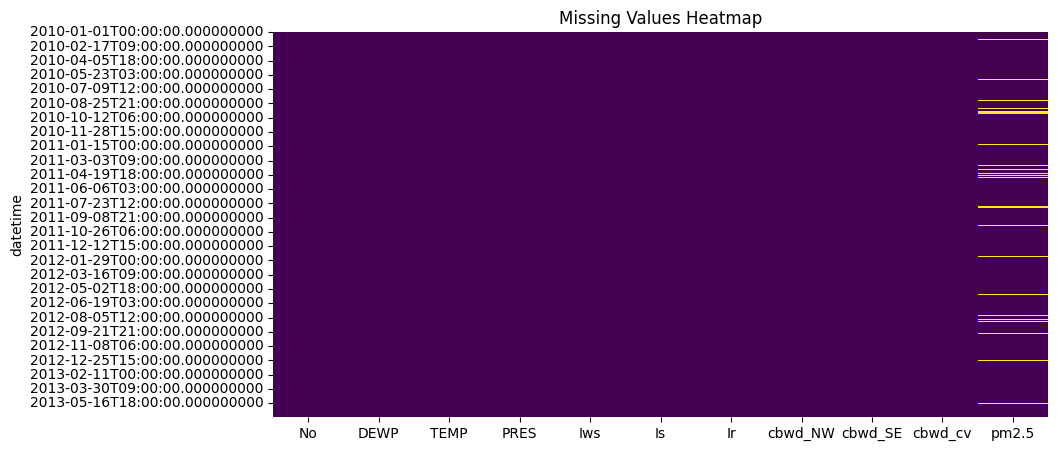

In [23]:
# Visualizing missing values
plt.figure(figsize=(10, 5))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

### **Distribution of PM2.5 Concentration**
This histogram (or density plot) shows how PM2.5 values are distributed.  
- **Right-skewed distribution** → Indicates frequent low PM2.5 values with occasional extreme pollution events.  
- **High variance** → Suggests a need for normalization or feature engineering.  
- **Outliers** → Extreme pollution levels that could influence model predictions.  

Understanding the distribution ensures that the model is trained on well-prepared, normalized data, preventing bias toward extreme values.  

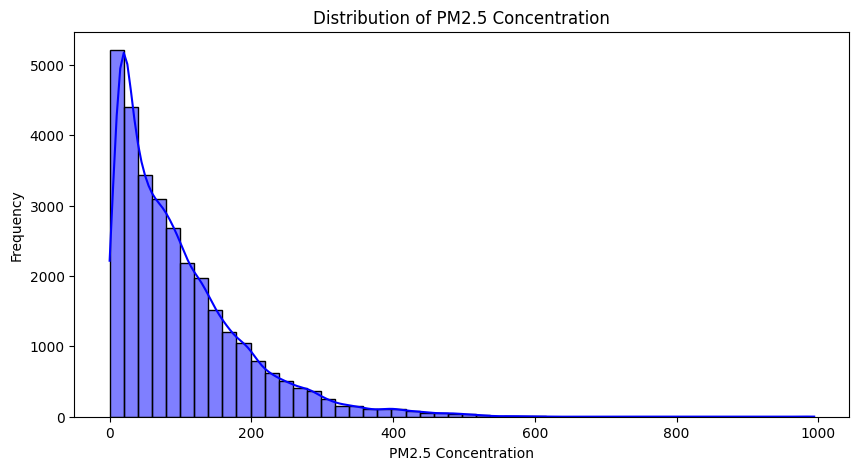

In [44]:
# Data Distribution of PM2.5
plt.figure(figsize=(10, 5))
sns.histplot(train['pm2.5'].dropna(), bins=50, kde=True, color='blue')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of PM2.5 Concentration')
plt.show()


### **Time Series Plot (PM2.5 Trends Over Time)**
This plot visualizes PM2.5 concentration over time.  
- Helps identify **seasonal patterns** and **trends** in air pollution.  
- Highlights potential anomalies (e.g., sudden pollution spikes due to weather changes).  
- Assists in selecting a suitable forecasting model, as LSTMs are effective in capturing sequential dependencies.  

Understanding time-based variations improves model feature engineering and forecasting accuracy.  

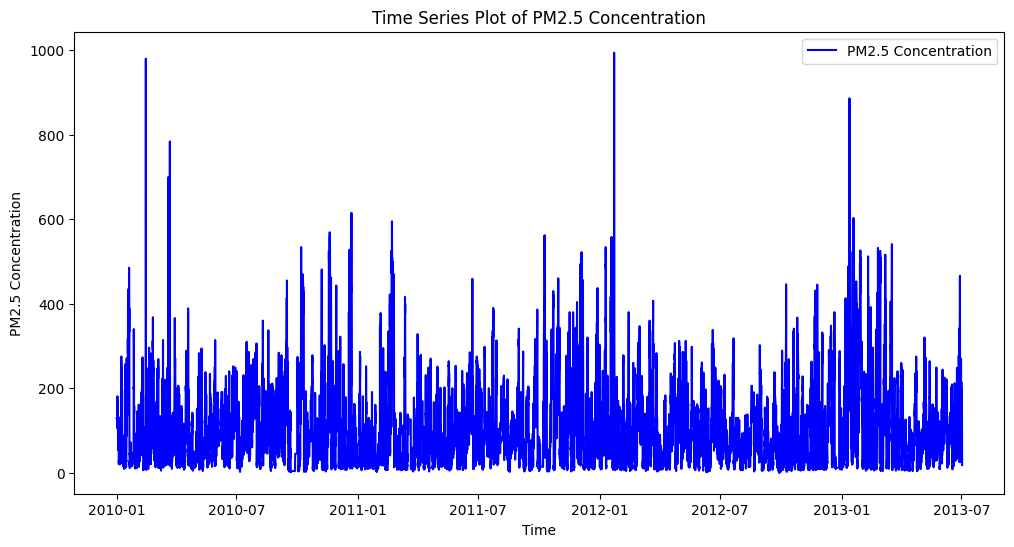

In [45]:
# Time Series Plot for PM2.5
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], label='PM2.5 Concentration', color='blue')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.title('Time Series Plot of PM2.5 Concentration')
plt.legend()
plt.show()


# Handling missing values


Missing values are a common issue in real-world datasets and need to be addressed properly to avoid negatively impacting model performance. In this section, I will identify any missing values in the dataset and apply strategies to handle them.

The steps include:
- Identifying columns with missing data and the extent of the missingness.
- Deciding on the appropriate imputation strategy, such as forward filling (for time-series data), interpolation, or even removal of certain rows/columns if necessary.
- Discussing why specific techniques are chosen based on the nature of the data (e.g., the sequential nature of time-series data).

By the end of this section, the dataset will have missing values appropriately handled, ensuring that the model does not face data quality issues during training.

---

In [24]:
# Handling the missing values in 'pm2.5' using forward fill and backward fill
train['pm2.5'].fillna(method='ffill', inplace=True)
train['pm2.5'].fillna(method='bfill', inplace=True)




<ipython-input-24-e9f0a682e53c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['pm2.5'].fillna(method='ffill', inplace=True)
<ipython-input-24-e9f0a682e53c>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['pm2.5'].fillna(method='ffill', inplace=True)
<ipython-input-24-e9f0a682e53c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior

In [25]:
# Ensuring no missing values remain
print("\nMissing Values in Training Data After Handling:")
print(train.isnull().sum())


Missing Values in Training Data After Handling:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64


# Separate features and target

In this section, we separate the features (input data) from the target (the variable we want to predict). For this problem, the target variable is the PM2.5 concentration, and the features are the various air quality and weather-related parameters.

The tasks involved here are:
- Isolating the features (such as temperature, humidity, and other weather data) and the target (PM2.5).
- Ensuring that the features and target are in a suitable format for input into a machine learning model.
- Checking the shapes and consistency of the data to make sure everything is set up properly for the model.

The goal is to prepare the data for the next step: building a model that will use these features to predict PM2.5 levels.

---

In [26]:
# Feature Engineering: Add time-based features
def add_time_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    # Cyclical encoding for hour and month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

In [27]:
# Adding the time featueres to the datasets
train = add_time_features(train)
test = add_time_features(test)

### **Feature Correlation Heatmap**
This heatmap shows relationships between features.  
- Identifies strong correlations with PM2.5 (important predictors).  
- Detects multicollinearity (redundant information).  
- Helps in feature selection and engineering.  

Reducing redundant features improves model efficiency and stability.

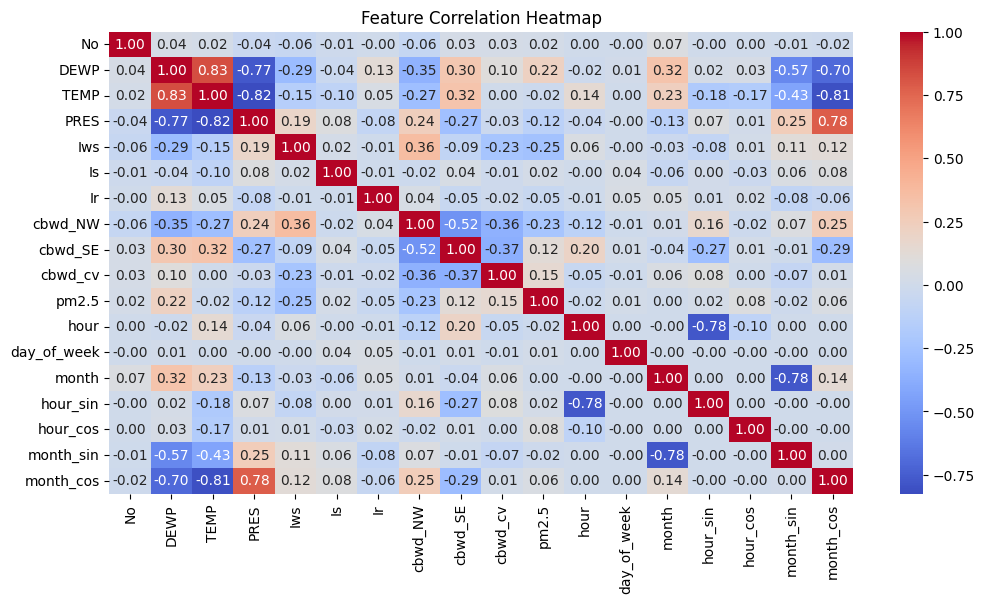

In [28]:
# Visualizing correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [29]:
# Separate features and target
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']
X_test = test.drop(['No'], axis=1)

In [30]:
# Normalize/Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Reshape data for LSTM input (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)


In [32]:
# Split training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, shuffle=False
)

# Build model

The model-building step is where we define the architecture of the neural network that will be used for forecasting the PM2.5 concentrations. In this section, we focus on constructing a Recurrent Neural Network (RNN) or Long Short-Term Memory (LSTM) model, which is ideal for sequential data like time-series.

The tasks in this section include:
- Designing the model architecture, which typically involves adding LSTM layers to handle sequential data, along with dropout layers to prevent overfitting.
- Compiling the model with the appropriate optimizer (such as Adam) and loss function (Mean Squared Error for regression tasks).
- Training the model using the preprocessed training data and validating it using a separate validation set to ensure the model generalizes well.

At the end of this section, the trained model should be capable of making predictions on unseen data, with the goal of minimizing the loss function and optimizing for accuracy.

---

In [33]:
# For building and training the LSTM model
def build_and_train_model(params):
    model = Sequential([
        Bidirectional(LSTM(params['lstm_units'], activation='relu',
                           input_shape=(X_train_split.shape[1], X_train_split.shape[2]),
                           return_sequences=True, kernel_regularizer=l2(0.01))),
        Dropout(params['dropout']),
        LSTM(params['lstm_units'] // 2, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    history = model.fit(
        X_train_split, y_train_split,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_data=(X_val_split, y_val_split),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Calculate validation loss
    val_loss = history.history['val_loss'][-1]
    return model, history, val_loss

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'lstm_units': trial.suggest_int('lstm_units', 32, 256),  # Randomly sample between 32 and 256
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),    # Randomly sample between 0.1 and 0.5
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),  # Fixed choices
        'learning_rate': trial.suggest_categorical('learning_rate', [0.001, 0.005, 0.01]),  # Fixed choices
        'epochs': trial.suggest_categorical('epochs', [50, 100])  # Fixed choices
    }

    # Build & train model
    model, history, val_loss = build_and_train_model(params)

    # Return the validation loss to minimize
    return val_loss

# Create an Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler())

# Run optimization
study.optimize(objective, n_trials=20)  # Number of trials




[I 2025-02-02 18:04:50,112] A new study created in memory with name: no-name-900ca17d-e306-428a-a30e-5e512c4e57e8
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-02-02 18:05:21,964] Trial 0 finished with value: 5600.43359375 and parameters: {'lstm_units': 47, 'dropout': 0.30199837093613113, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 100}. Best is trial 0 with value: 5600.43359375.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-02-02 18:06:38,780] Trial 1 finished with value: 6021.19482421875 

In [34]:
# Best parameters
print("Best Parameters:", study.best_params)

# Best validation loss
print("Best Validation Loss:", study.best_value)


Best Parameters: {'lstm_units': 37, 'dropout': 0.320343293315899, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 50}
Best Validation Loss: 5593.56640625


In [35]:
# Training the final model with the best parameters
print("Training the final model with the best parameters...")
final_model, final_history, final_val_loss = build_and_train_model(study.best_params)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the final model with the best parameters...


In [43]:
# Make predictions on the training set
train_predictions = final_model.predict(X_train_split).flatten()

# Calculate Training MSE (Mean Squared Error)
train_mse = np.mean((y_train_split - train_predictions) ** 2)

# Calculate Training RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(train_mse)

# Print the results
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")

767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Training MSE: 3867.0992
Training RMSE: 62.1860


### **Training and Validation Loss Curve**
This plot tracks model learning over epochs.  
- **Decreasing training & validation loss** → Good learning.  
- **Diverging losses** → Overfitting risk (needs early stopping).  
- **Consistently high loss** → Possible underfitting.  

Guides tuning hyperparameters like dropout, learning rate, and number of epochs.

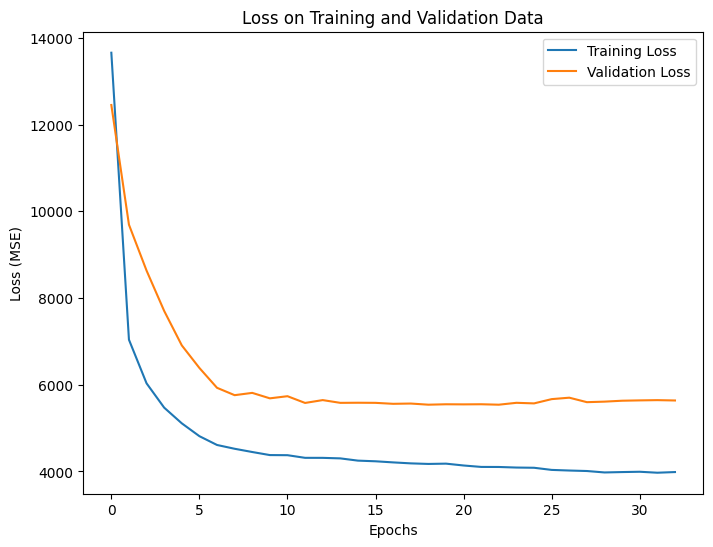

In [37]:
# Visualize training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Loss on Training and Validation Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

### **Actual vs. Predicted Values Plot**
This plot compares the predicted PM2.5 values to actual values.  
- **Tightly clustered points around the diagonal line** → Model makes accurate predictions.  
- **Large deviations from the line** → Model struggles with certain time periods or extreme values.  
- Helps diagnose whether the model **underfits, overfits, or generalizes well**.  

A well-aligned plot confirms that the model effectively captures air quality trends.  

---

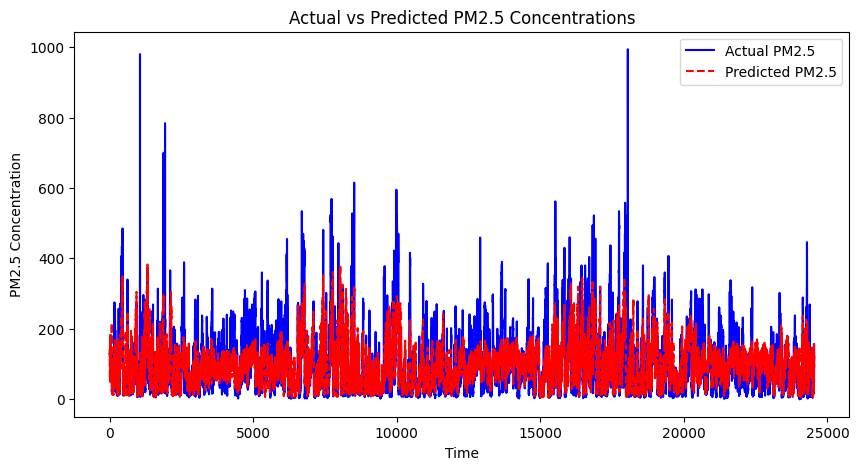

In [46]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_train_split.values, label='Actual PM2.5', color='blue')
plt.plot(train_predictions, label='Predicted PM2.5', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.title('Actual vs Predicted PM2.5 Concentrations')
plt.legend()
plt.show()

## Model Architecture Summary

### **Model Architecture Diagram**
Displays the LSTM model structure.  
- Ensures correct layer sequence and input-output shapes.  
- Verifies components like bidirectional LSTM, dropout, and dense layers.  
- Useful for debugging and model optimization.  

A well-structured model effectively captures time dependencies in air quality data.

Model Architecture Summary:



Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_20 (Bidirectional)     │ (None, 1, 74)               │          15,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1, 74)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 18)                  │           6,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              19 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,099 (266.02 KB)

 Trainable params: 22,699 (88.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,400 (177.35 KB)

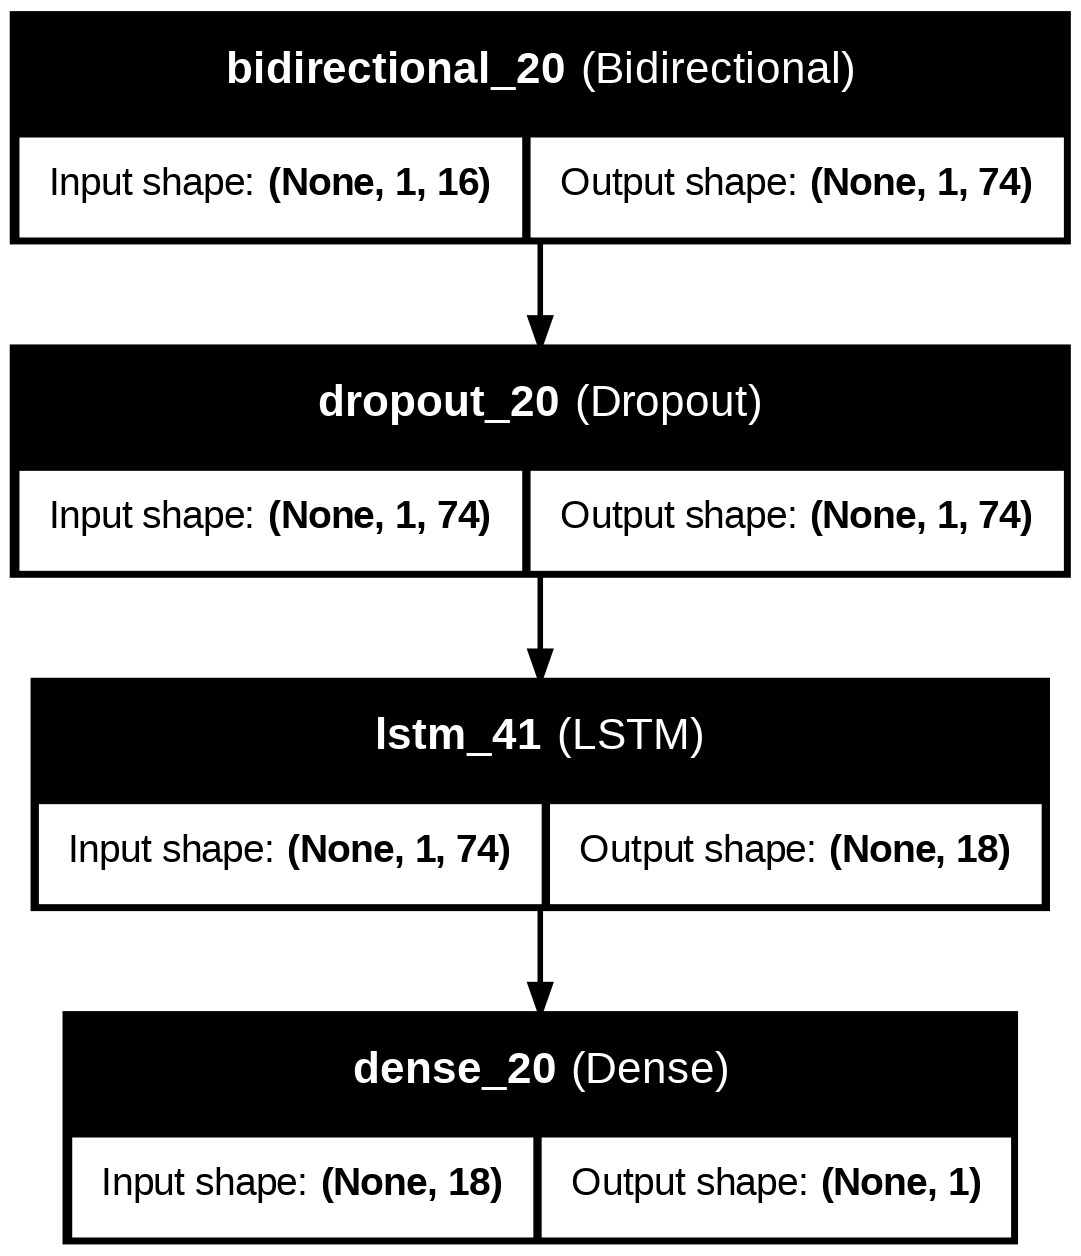

In [41]:

# Display model architecture summary
print("Model Architecture Summary:\n")
final_model.summary()

# Justification of the Design Choices
"""
The implemented model uses a Bidirectional LSTM architecture, which allows the model to learn
both past and future dependencies in the time series data. Here are the key design choices:

- **Bidirectional LSTM Layer**: This layer is used to capture both forward and backward dependencies
  in the time series data, which is particularly helpful in forecasting applications like air quality.
  The LSTM units are regularized using L2 regularization to prevent overfitting.

- **Dropout Layer**: Dropout is used to regularize the model and prevent overfitting by randomly setting
  a fraction of input units to zero during training. The dropout rate was optimized during the hyperparameter
  tuning process.

- **Second LSTM Layer**: A second LSTM layer with fewer units is used to capture deeper temporal relationships
  without overfitting the model. This helps the model generalize better.

- **Dense Layer**: A fully connected layer is used as the output layer, where the single unit represents
  the prediction of PM2.5 values.

- **Optimizer**: The Adam optimizer is used because it adapts the learning rate during training and is efficient
  for complex models like LSTMs.

- **Loss Function**: Mean Squared Error (MSE) is used as the loss function, which is standard for regression
  tasks like forecasting PM2.5 levels.
"""

# Visualization of Model Architecture (using plot_model)
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(final_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the diagram in the notebook
from IPython.display import Image
Image(filename='model_architecture.png')


# Submission

In [47]:
# Make predictions on the test set
predictions = final_model.predict(X_test_scaled).flatten()
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),  # Ensures single-digit hours are not zero-padded
    'pm2.5': predictions
})


# Sort the submission by 'row ID' to match the test set order
submission = submission.sort_values(by='row ID')

# Verify the submission file
print("\nSubmission File Overview:")
print(submission.head())

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/air_quality_forecasting/latsubOptuna.csv', index=False, encoding='utf-8')

print("Submission file created.")


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Submission File Overview:
                 row ID  pm2.5
6   2013-07-02 10:00:00     51
7   2013-07-02 11:00:00     50
8   2013-07-02 12:00:00     42
9   2013-07-02 13:00:00     41
10  2013-07-02 14:00:00     39
Submission file created.
